# A Statistical Study on GP practice prescribing data in England

This work is based on the data set published by NHS Digital ([available here](https://data.gov.uk/dataset/prescribing-by-gp-practice-presentation-level)); prescription data at practice level were given in monthly packs. Here I have picked the most recent 18 months available (2017/02 - 2018/07), and try to normalize individual practice's performance by the number of general practitioners it has. The intended readers of the report below are fellow data scientists, in order to showcase my _data query, statistics_ and _machine learning skills_. Code involved but not shown here (Spark commands, k-means clustering) are included in Relavant_codes.ipynb.
#### Tools used:
_Spark_ was used to read the original data (GB level); a trick to protect my macbook while doing this is to prop it up using paper towel wrapped ice packs, so the cpu won't overheat.
_SparkSQL_ and _Pandas_ were used for the following analysis, as well as _sci-kit learn_.
_Matplotlib_ was used for the majority of figure making, while _Folium_ was used for plotting geolocation data.


In [65]:
import os
import re
import numpy as np
import dill
import pandas as pd
from matplotlib import pyplot as plt
import geojson
import folium

plt.rcParams["figure.figsize"] = [8,6]
plt.rcParams["font.size"] = 14

## An overview of the data
Here is a histogram of monthly prescription counts for individual practices. There are clearly two component here - a Gaussian-like blob at 1200 prescriptions/month, and a sharp peak at the origin.

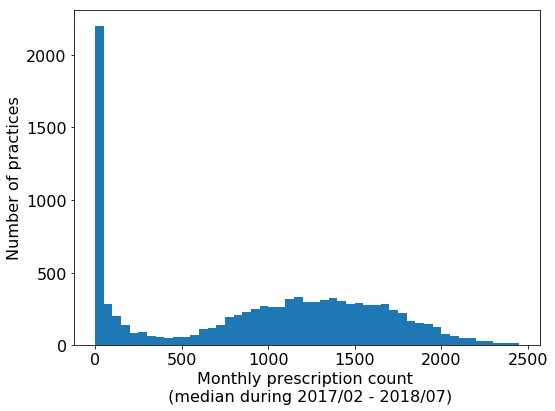

In [32]:
#Compute the statistics with a GroupBy.
df_grouped = dill.load(open('grouped_records_cost.pkd', 'rb'))
df_stats_all = df_grouped.groupby('Practice_Code')['Count','NIC_sum']\
                .agg([np.median,np.var]).dropna()
#Rename the columns
df_stats_all.columns = [' '.join(col).strip() for col in df_stats_all.columns.values]
median = df_stats_all['Count median'].tolist()

#Plot
fig,ax = plt.subplots()
ax.hist(np.asarray(median),bins=np.arange(50)*50)
ax.set_xlabel('Monthly prescription count \n (median during 2017/02 - 2018/07)')
ax.set_ylabel('Number of practices')
fig.tight_layout()

Grouping the practices by how long they've been around separates these two components nicely. The practices with an age less than 80 months are likely either new business still trying to figure out their way around; or dummy practices in the record. Here all the records in the less-than-80 bin will be discarded for the following analysis.

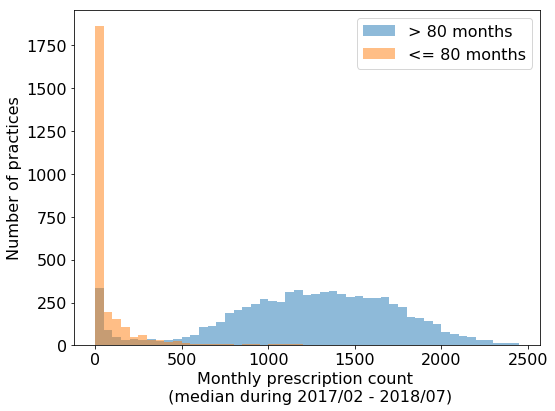

In [33]:
#Group the data by how long the practice has been around
df_prac_age = dill.load(open('df_prac_age.pkd', 'rb'))
df = df_stats_all.join(df_prac_age.set_index('Practice_Code'))
group1 = df.loc[df['Months'] > 80]
group2 = df.loc[df['Months'] <= 80]
median1 = group1['Count median'].tolist()
median2 = group2['Count median'].tolist()

#Plot
fig,ax = plt.subplots()
ax.hist(np.asarray(median1),bins=np.arange(50)*50,alpha=0.5,label='> 80 months')
ax.hist(np.asarray(median2),bins=np.arange(50)*50,alpha=0.5,label='<= 80 months')
ax.legend()
ax.set_xlabel('Monthly prescription count \n (median during 2017/02 - 2018/07)')
ax.set_ylabel('Number of practices')
fig.tight_layout()

Next is an attempt to identify how many general practitioners (GPs) each practice has. Unfortunately such information is not provided in this data set, and has to be acquired by other means. Below a small sample of practices were looked up on [www.nhs.uk](www.nhs.uk) and their number of GPs plotted in a scattered plot. We can see the distributions are largely overlapping - This is likely due to the fact that many GPs work part-time in specific practices; another reason being data fetched from [www.nhs.uk](www.nhs.uk) do not necessarily match the time window investigated here.

Text(0,0.5,'Var monthly prescriptions')

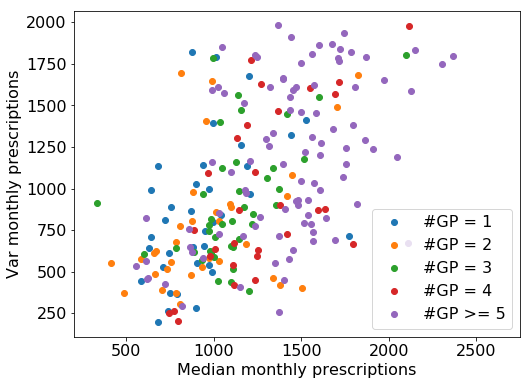

In [45]:
df_sample_ngp = pd.read_csv('df_sample_ngp.csv').dropna()

fig,ax = plt.subplots()
for i in range(1,5):
    df = df_sample_ngp.loc[df_sample_ngp['nGP']==i]
    df = df.set_index('Practice_Code').join(df_stats_all)
    s = '#GP = '+str(i)
    median = np.asarray(df['Count median'].tolist())
    var = np.asarray(df['Count var'].tolist())
    ax.plot(median,var,'o',label=s)
df = df_sample_ngp.loc[df_sample_ngp['nGP']>=5.]
df = df.set_index('Practice_Code').join(df_stats_all)
s = '#GP >= 5'
median = np.asarray(df['Count median'].tolist())
var = np.asarray(df['Count var'].tolist())
ax.plot(median,var,'o',label=s)

ax.set_xlim((200,2750))
ax.legend()
ax.set_xlabel('Median monthly prescriptions')
ax.set_ylabel('Var monthly prescriptions')

Therefore instead of fetching information from the web I decided to go for a measure of 'effective' number of GPs, infered from a statistical approach.

Assume prescriptions contain two types: 1. Monthly refills for patients with a chronological condition; 2. For incidental visits like accidents, flu, etc. The former should be a constant in a relatively short time-window, while the latter is assumed to follow a Poisson distribution. Assume all GPs' performance fall under the same Poisson distribution, the variation computed for an individual practice should be linear to the number of GPs it has.

Even though the feature considered here is an 'effective' number of GPs (thus continuous), it is still assumed to possess some discrete character (broadened \delta functions). Therefore a K-means clustering is performed on the variation of monthly prescriptions count as a classification method.

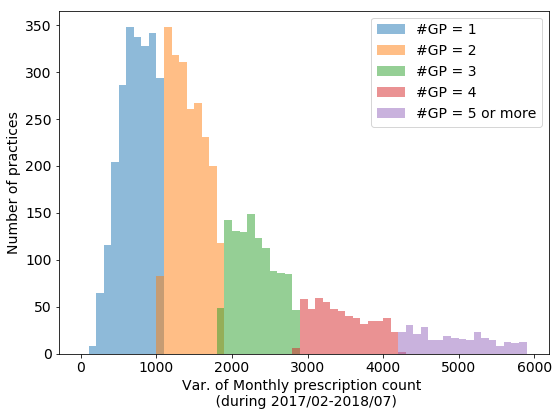

In [63]:
kmeans = dill.load(open('df_kmeans.pkd', 'rb'))
fig,ax = plt.subplots()
for i in range(5):
    ki = kmeans.loc[kmeans['nGP'] == i+1]
    var = ki['Count var'].tolist()
    s = '#GP = '+str(i+1)
    if i+1 == 5:
        s = s+' or more'
    ax.hist(np.asarray(var),bins=np.arange(60)*100,stacked=True,alpha=0.5,label=s)
ax.legend()
ax.set_xlabel('Var. of Monthly prescription count \n (during 2017/02-2018/07)')
ax.set_ylabel('Number of practices')
fig.tight_layout()

Grouping the practices and normalizing the performance by infered number of GPs they have gives the histogram below. Since after normalization the peaks roughly overlap with each other, which agrees with the assumption that all GPs' performance fall under the same Poisson distribution.

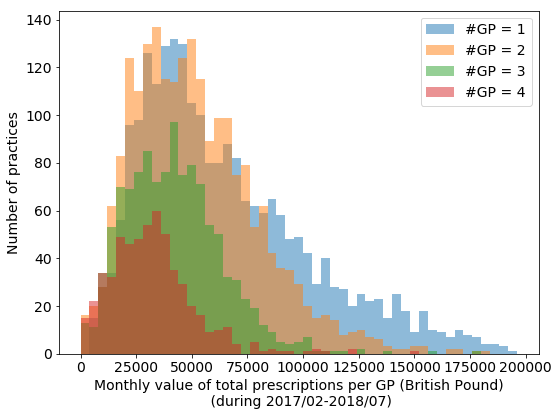

In [55]:
fig,ax = plt.subplots()
for i in range(4):
    ki = kmeans.loc[kmeans['nGP'] == i+1]
    median = ki['NIC_sum median'].tolist()
    s = '#GP = '+str(i+1)
    if i+1 == 5:
        s = s+' or more'
    ax.hist(np.asarray(median)/(i+1),bins=np.arange(50)*2.e5/50,stacked=True,alpha=0.5,label=s)
ax.legend()
ax.set_xlabel('Monthly value of total prescriptions per GP (British Pound)\n (during 2017/02-2018/07)')
ax.set_ylabel('Number of practices')
fig.tight_layout()

Now that normalized performance data are available, plot them on a map. Below figure plots how practices in each region performs, judging by the median of normalized value of total prescriptions per month.

In [66]:
kmeans['Normalized NIC sum'] = kmeans['NIC_sum median']/kmeans['nGP']
kmeans['Normalized count'] = kmeans['Count median']//kmeans['nGP']
df_geo = dill.load(open('df_geo.pkd', 'rb'))
kmeans_geo = kmeans.join(df_geo.set_index('Practice_Code'))

df = kmeans_geo.loc[kmeans_geo['nGP'] <=4].copy()
df = df.groupby('Postcode_Area')['Normalized NIC sum'].agg([np.median,'count'])
df = df.loc[df['count'] >15]
df['Postcode_Area'] = df.index

post_area = os.path.join(os.path.abspath(os.path.curdir), 'Areas.json')
m = folium.Map(location=[53, -2], zoom_start=6)

folium.Choropleth(
    geo_data=post_area,
    data=df,
    columns=['Postcode_Area','median'],
    key_on='feature.properties.name',
    bins=8,
    fill_color='BuPu',
    fill_opacity=.9,
    line_opacity=0.5,
    nan_fill_opacity=0.
).add_to(m)

folium.LayerControl().add_to(m)
m

Compare that to the population/nGP plot below shows that GPs responsible for a larger population tend to prescribe more values of prescriptions.

In [67]:
#Read population data from csv
df_pop = pd.read_csv(os.path.join(os.path.abspath(os.path.curdir), 'pop_density.csv'))
def select_area(s):
    return s.partition('-')[0].strip()
df_pop['Postcode_Area'] = df_pop['postcode areas'].apply(select_area)
df_pop = df_pop.drop(columns='postcode areas')

df = df_pop.copy().set_index('Postcode_Area')
df['GP_sum'] = filtered_data.join(df_geo.set_index('Practice_Code'))\
                                    .groupby('Postcode_Area').apply(len)
df['Postcode_Area'] = df.index
df['Popolation_per_Practice'] = df['Population']/df['GP_sum']
#df = df.drop(index=['AL'])

m = folium.Map(location=[53, -2], zoom_start=6)

folium.Choropleth(
    geo_data=post_area,
    name='Pop_per_Practice',
    data=df,
    columns=['Postcode_Area','Popolation_per_Practice'],
    key_on='feature.properties.name',
    bins=8,
    fill_color='PiYG',
    fill_opacity=.9,
    line_opacity=0.5,
    nan_fill_opacity=0.
).add_to(m)

folium.LayerControl().add_to(m)
m